In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy
from dataset import Dataset

# Constants

In [2]:
DATASET_PATH = 'dataset/bag/'
NUM_BIN = 8

In [3]:
data = Dataset(DATASET_PATH)

In [4]:
BAND = 255 /NUM_BIN
def to_b_num(img):
    assert isinstance(img, numpy.ndarray)
    b = (img //BAND).astype(int)
    return numpy.minimum(b, 7)

# Kernel

原本的 epancechnikov profile
$$
k(x)=\begin{cases} 
    \frac{1}{2} c^{-1}_d (d+2) (1-x)   & x \leqq 1
    \\
    0 & otherwise
   \end{cases}
$$

本次計算中使用方式皆為 $K(x) = C k{({\|\frac{y-x}{h}\|})}$ 之形式，故改寫為
$$
K(x) = \begin{cases} 
    C(1-x^2)   & x \leqq 1
    \\
    0 & otherwise
   \end{cases}
\\
C = sum(K)
$$


In [5]:
def create_kernel(r, c):
    """
    create kernel with epancechnikov profile
    
    @param r, c: size
    """
    rr = numpy.arange(r) / (r-1) *2 -1
    cc = numpy.arange(c) / (c-1) *2 -1
    C, R = numpy.meshgrid(cc, rr)
    X2 = C**2 + R**2
    
    kernel = numpy.maximum(1-X2, 0)
    return kernel / numpy.sum(kernel)

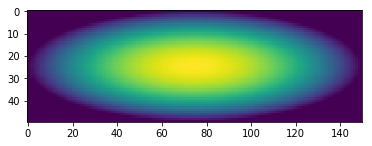

In [6]:
plt.imshow(create_kernel(50, 150))

# Target model

In [7]:
def create_target_model(target_img):
    B = to_b_num(target_img)
    
    kernel = create_kernel(*target_img.shape[:2])
    
    M = numpy.empty((NUM_BIN, 3))
    for b in range(NUM_BIN):
        for ch in range(3):
            M[b, ch] = numpy.sum(kernel[B[:,:,ch]==b])
            
    return M

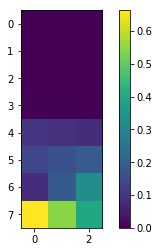

In [8]:
test_tm = create_target_model(data.target(0))

#
plt.imshow(test_tm)
plt.colorbar()
plt.show()

# Target Candidate

In [9]:
def create_target_candidate(img, center, diameter):
    """
    @param orig_img  the entire img
    @param num_bin   the num of hist bins
    @param center    center (x, y)
    @param diameter  mask diameter, aka normalized factor
    """
    R, C = img.shape[:2]
    
    c, r = center
    c = int(c)
    r = int(r)
    
    radius = int(min(diameter/2, R-r, C-c))
    
    target_img = img[r-radius:r+radius, c-radius:c+radius]
    return create_target_model(target_img)

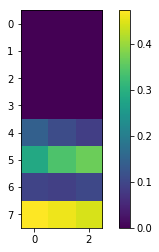

In [10]:
test_tc = create_target_candidate(data.imgs[1], [365, 194], 132)

plt.imshow(test_tc)
plt.colorbar()
plt.show()

# Bhattacharyya Coefficient Weight

In [11]:
def calc_weight(img, target_model, target_candidate, center, diameter):
    assert isinstance(center, numpy.ndarray)
    
    # pre-calculate weight coef
    C = numpy.zeros((NUM_BIN, 3))
    idx = target_candidate > 0
    C[idx] = numpy.sqrt(target_model[idx] / target_candidate[idx])
    
    # estimate range
    diameter = int(diameter)

    cnr_c, cnr_r = center.astype(int) - (diameter >> 1)
    target_img = to_b_num(img[cnr_r:cnr_r+diameter, cnr_c:cnr_c+diameter])

    #
    r, c, _ = target_img.shape
    weight = numpy.empty((r, c))
    for i in range(target_img.shape[0]):
        for j in range(target_img.shape[1]):
            b_val = target_img[i, j]
            
            c_val = 1.0
            for ch in range(3):
                c_val *= C[b_val[ch], ch]
            weight[i, j] = c_val
    
    # create G(X), derivation of kernel k(x)
    rr = numpy.arange(r) / (r-1) *2 -1
    cc = numpy.arange(c) / (c-1) *2 -1
    
    C, R = numpy.meshgrid(cc, rr)
    G = (C**2 + R**2) < 1
    
    # apply mask G(X)
    density = weight *G
    density /= numpy.sum(density)
    
    return density

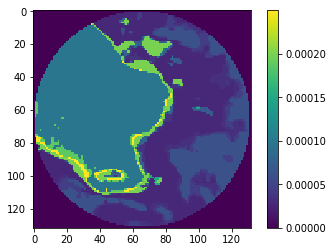

In [12]:
test_D = calc_weight(data.imgs[1], test_tm, test_tc, numpy.array([365, 194]), 132)

#
plt.imshow(test_D)
plt.colorbar()
plt.show()

# Meanshift

In [13]:
def meanshift(density):
    """
    a round of meanshift in the algorithm
    
    @param  weight weight of the target candidates
    @return        translation, in (x, y)
    """
    # create G(X), derivation of kernel k(x)
    r, c = density.shape
    
    rr = numpy.arange(r) / (r-1) *2 -1
    cc = numpy.arange(c) / (c-1) *2 -1
    
    C, R = numpy.meshgrid(cc, rr)
    
    # measure shift
    C *= density
    R *= density
    
    sft_c = numpy.sum(C) *c
    sft_r = numpy.sum(R) *r
    
    return int(sft_c), int(sft_r)
    

In [14]:
meanshift(test_D)

(-18, -2)

# Bhattacharyya Coefficient Maximization

## Given
the target model ${\{\hat{q_u}\}}_{u=1\dots m}$ and its location $\hat{y_0}$ in the previous frame

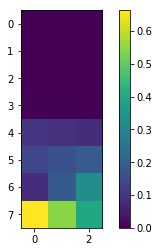

In [15]:
q = create_target_model(data.target(0))

#
plt.imshow(q)
plt.colorbar()
plt.show()

frame 0


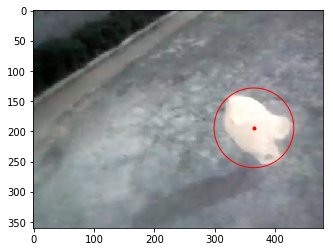

frame 1, same 'y' and 'h'


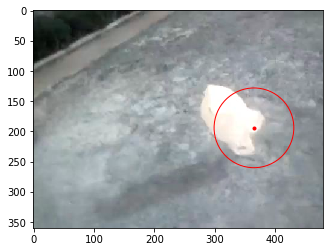

In [16]:
y0 = numpy.array([365, 194], numpy.int32)
h = int(132)

#
def show_range(idx):
    ax = plt.gca()
    ax.imshow(data.imgs[idx])
    ax.add_artist(plt.Circle(y0, h/2, color='r', fill=False))
    ax.plot(*y0, 'r.')
    plt.show()
    
print('frame 0')
show_range(0)

print("frame 1, same 'y' and 'h'")
show_range(1)

## Step. 1

initialize the location of the target in the current frame with $\hat{y_0}$, compute 
$$
{\{ \hat{p}_u {( \hat{y}_0 )} \}}_{u=1 \dots m}
$$

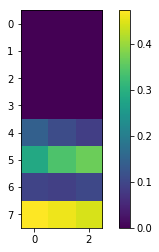

In [17]:
p_y0 = create_target_candidate(data.imgs[1], y0, h)

#
plt.imshow(p_y0)
plt.colorbar()
plt.show()

and evaluate
$$
\rho{[ \hat{p}{( \hat{y}_0 )}, \hat{q} ]}
=
\sum_{u=1}^{m}{\sqrt{
\hat{p}_u( \hat{y}_0 ) \hat{q}_u
}}
$$

In [18]:
rho0 = numpy.sum(numpy.sqrt(p_y0 * q))
rho0

2.898888144536544

## Step. 2

derive the weights ${\{w_i\}}_{i=1\dots n_h}$ according to
$$
w_i = \sum^m_{u=1}{
    \sqrt{
        \frac{ \hat{q}_u }{ \hat{p}_u {( \hat{y}_0 )} }
        \delta
        [ b({x_i}) - u ]
    }
}
$$

and apply mask $g(x) = -k'(x)$, then we get 
$$
d_i = {w_i} {g \left({ \left\| \frac{
        \hat{y}_0 - x_i
    }{
        h
    } \right\| }^2 \right)}
$$

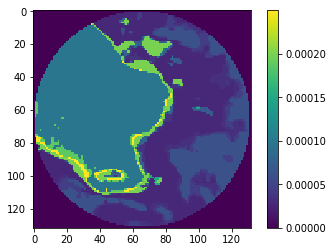

In [19]:
D = calc_weight(data.imgs[1], q, p_y0, y0, h)

#
plt.imshow(D)
plt.colorbar()
plt.show()

## Step. 3

find the next location of target candifate accroding to
$$
\hat{y}_1 = \frac{
    \sum^{n_h}_{i=1}{x_i d_i}
}{
    \sum^{n_h}_{i=1}{d_i}
} + \hat{y}_0
$$

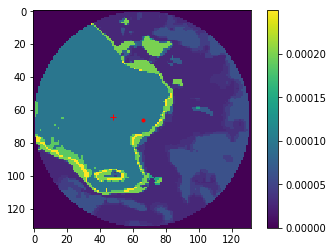

shift: -18, -2
y1: [347 192]


In [20]:
x, y = meanshift(D)
y1 = numpy.array((x, y)) + y0

#
plt.imshow(D)
plt.plot(h/2, h/2, 'r.')
plt.plot(x+h/2, y+h/2, 'r+')
plt.colorbar()
plt.show()

print(f'shift: {x}, {y}')
print(f'y1: {y1}')

## Step. 4

compute $
{\{ \hat{p}_u {( \hat{y}_1 )} \}}_{u=1 \dots m}
$

In [21]:
p_y1 = create_target_candidate(data.imgs[1], y1, h)
p_y1

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  4.48857624e-05,   0.00000000e+00,   0.00000000e+00],
       [  6.25014743e-02,   4.86078047e-02,   3.87332396e-02],
       [  2.07632380e-01,   2.40385082e-01,   2.56737404e-01],
       [  9.91406646e-02,   9.67343347e-02,   1.26887597e-01],
       [  6.30680595e-01,   6.14272778e-01,   5.77641759e-01]])

and evaluate
$$
\rho{[ \hat{p}{( \hat{y}_1 )}, \hat{q} ]}
=
\sum_{u=1}^{m}{\sqrt{
\hat{p}_u( \hat{y}_1 ) \hat{q}_u
}}
$$

In [22]:
rho1 = numpy.sum(numpy.sqrt(p_y1 * q))
rho1

2.9346277065382429

## Step. 5

while
$$\rho{[ \hat{p}{( \hat{y}_1 )}, \hat{q} ]} < \rho{[ \hat{p}{( \hat{y}_0 )}, \hat{q} ]}$$

do
$$ \hat{y}_1 \leftarrow \frac{1}{2}( \hat{y}_0 + \hat{y}_1 ) $$

evaluate
$$\rho{[ \hat{p}{( \hat{y}_1 )}, \hat{q} ]}$$

In [23]:
while rho1 < rho0:
    y1 = (y0 + y1) /2
    p_y1 = create_target_candidate(data.imgs[1], y1, h)
    
    rho0 = rho1
    rho1 = numpy.sum(numpy.sqrt(p_y1 * q))
y1

array([347, 192])

## Step. 5

if $\| \hat{y}_1 - \hat{y}_0 \| < \epsilon$ then stop

otherwise set $\hat{y}_1 \leftarrow \hat{y}_0$ and go to step (2)

In [24]:
while True:
    W = calc_weight(data.imgs[1], q, p_y1, y1, h)
    x, y = meanshift(W)
    if abs(x) < 2 and abs(y) < 2:
        break
    
    y1 = numpy.array((x, y)) + y1
    p_y1 = create_target_candidate(data.imgs[1], y1, h)

frame: before shift


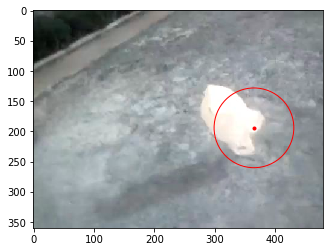

frame: after shift


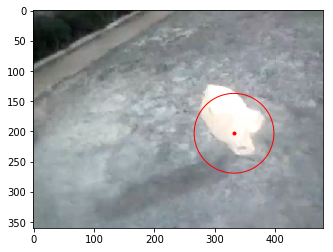

In [25]:
print('frame: before shift')
show_range(1)

print('frame: after shift')
ax = plt.gca()
ax.imshow(data.imgs[1])
ax.add_artist(plt.Circle(y1, h/2, color='r', fill=False))
ax.plot(*y1, 'r.')
plt.show()